In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms

from datasets import *
from styleExtraction import *

NpzFile 'Data\\FONTS\\character_font.npz' with keys: images, labels


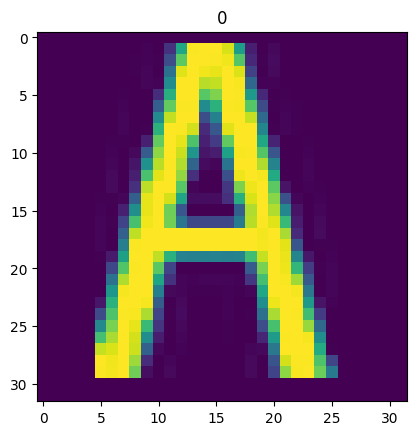

torch.Size([500, 1, 28, 28])


In [11]:

dataPath = os.path.normpath(r'Data\FONTS\character_font.npz')

loadedData = np.load(dataPath)

print(loadedData)

images = loadedData['images']
labels = loadedData['labels']


fontNum = 0

baseSample = images[fontNum*26]
sample_tensor = torch.from_numpy(baseSample).unsqueeze(0).to(torch.float32)

plt.imshow(baseSample), plt.title(0), plt.show()

# TODO: Try more transforms
randomRotation = transforms.RandomApply([transforms.RandomRotation((-15, 15))])
randomBlur = transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.3, 0.6))], p=0.25)

transform = transforms.Compose([
    randomRotation,
    randomBlur,
    transforms.RandomAffine(degrees=(0, 0), translate=(0.05, 0.1), scale=(0.9, 1.1), shear=(0, 1)),
    transforms.Resize((28, 28)),
])


newSamples = []

for _ in range(500):
    transformed = transform(sample_tensor)
    newSamples.append(transformed)
    
stackedSamples = torch.stack(newSamples, dim=0)

print(stackedSamples.shape)

grid = make_grid(stackedSamples, normalize=True, nrow=int(np.sqrt(stackedSamples.shape[0])))
img = torchvision.transforms.ToPILImage()(grid)
img.show()


In [12]:

numClusters = 8

# Get a combined train and test set since validation is for losers
trainset = getFullDataset()


flattenedData = torch.flatten(stackedSamples, start_dim=1).numpy()


LETTER_ID = 1

# Get formatted information about what data indices belong to what cluster
CLUSTER_DATA, CLUSTERINGS, REDUCTIONS = getClusterDataForLetters(trainset=trainset, numClusters=numClusters, showPlots=False, targetClasses=[1], getMappingInfo=True)


clustering = CLUSTERINGS[LETTER_ID]
reduction = REDUCTIONS[LETTER_ID]


reduced = reduction.transform(flattenedData)
clusterLabels = clustering.predict(reduced)

print(clusterLabels)

indices, clusterCounts = np.unique(clusterLabels, return_counts=True)
print(clusterCounts)
print(indices)

mostCommonCluster = indices[np.argmax(clusterCounts)]
print(f'Most common cluster: {mostCommonCluster}')


Letter a cluster counts:
[347, 674, 584, 562, 784, 544, 321, 380]
[3 3 3 3 7 3 3 3 3 3 3 7 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 3 3 3 3 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 3 3 3 3
 3 4 3 7 3 3 7 3 3 3 3 3 3 3 3 3 3 3 7 7 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3
 3 3 2 3 3 3 3 7 3 3 3 3 3 3 3 7 3 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 7
 3 7 3 3 7 3 3 3 7 3 3 3 3 3 3 3 7 3 3 3 3 7 3 3 3 3 3 3 3 4 3 7 3 3 7 3 3
 3 3 3 3 3 4 3 3 3 7 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 7 3 3 3 3 7 3 3 3 3
 3 7 3 3 3 3 3 3 3 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 7 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 3 7 3 3 3 3 3 7 4 4 3 4 3 3 3 3 3 4 3 3 3 3 4 3 3 3 3
 7 4 7 3 3 3 3 7 3 3 7 3 3 7 3 3 3 3 3 3 3 7 3 3 3 3 7 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 3 3 3 3 7 3 3 7 3 7 7 3 7 3 3 3 3 3 3 3 3 3 3 7 3 3 4 3 3
 3 3 3 3 3 3 3 3 4 3 7 3 3 3 3 3 3 3 3 3 7 3 3 3 3 7 3 3 3 3 3 3 3 3 3 3 3
 3 3 7 3 3 3 3 3 7 3 3 3 3 3 3 3 3 3 7 3 7 3 3 3 3 3 7 7 3 3 3 3 3 3 3 7 3
 4 3 3 3 3 3 3 3 3 7 7 3 3 3 3 3 3

In [13]:
# Create individual data subsets for each cluster
subsets = createSubsets(trainset, CLUSTER_DATA)

currentSubset = subsets[1]
currentSubset: ClusterDataset

currentSubset.visualizeClusterDataset()


In [14]:
# Add our "handwriting" samples to the best cluster and revisualize
currentSubset.addSamplesToData(newFeatures=stackedSamples, newLabels=torch.full((stackedSamples.shape[0],), fill_value=mostCommonCluster))

currentSubset.visualizeClusterDataset()
